# Installation and imports


In [1]:
!pip install -q catboost xgboost scikit-learn opendatasets



[notice] A new release of pip is available: 25.1.1 -> 25.3
[notice] To update, run: C:\Python312\python.exe -m pip install --upgrade pip


In [3]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import MinMaxScaler, LabelEncoder
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.metrics import (accuracy_score, classification_report,
                             confusion_matrix, f1_score, precision_score,
                             recall_score)
from catboost import CatBoostClassifier

import joblib
import warnings
warnings.filterwarnings('ignore')

# Configuration



In [4]:
RANDOM_STATE = 42
TEST_SIZE = 0.2
np.random.seed(RANDOM_STATE)


# Data Loading



In [5]:
data = pd.read_csv('Crop_recommendation.csv')
print(f"Shape: {data.shape}")
print(f"Classes: {data['label'].nunique()}\n")
display(data.head(10))


Shape: (2200, 8)
Classes: 22



,N,P,K,temperature,humidity,ph,rainfall,label
0,90,42,43,20.879744,82.002744,6.502985,202.935536,rice
1,85,58,41,21.770462,80.319644,7.038096,226.655537,rice
2,60,55,44,23.004459,82.320763,7.840207,263.964248,rice
3,74,35,40,26.491096,80.158363,6.980401,242.864034,rice
4,78,42,42,20.130175,81.604873,7.628473,262.717340,rice
5,69,37,42,23.058049,83.370118,7.073454,251.055000,rice
6,69,55,38,22.708838,82.639414,5.700806,271.324860,rice
7,94,53,40,20.277744,82.894086,5.718627,241.974195,rice
8,89,54,38,24.515881,83.535216,6.685346,230.446236,rice
9,68,58,38,23.223974,83.033227,6.336254,221.209196,rice


# Data Preparation


In [6]:
X = data[['N', 'P', 'K', 'temperature', 'humidity', 'ph', 'rainfall']]
Y = data['label']

scaler = MinMaxScaler()
encoder = LabelEncoder()

X_scaled = scaler.fit_transform(X)
Y_encoded = encoder.fit_transform(Y)

X_train, X_test, Y_train, Y_test = train_test_split(
    X_scaled, Y_encoded,
    test_size=TEST_SIZE,
    random_state=RANDOM_STATE,
    stratify=Y_encoded
)

print(f"Train samples: {X_train.shape[0]}")
print(f"Test samples: {X_test.shape[0]}\n")


Train samples: 1760
Test samples: 440



# Model Training


In [7]:
model = CatBoostClassifier(
    iterations=1000,
    learning_rate=0.1,
    depth=6,
    loss_function='MultiClass',
    random_seed=RANDOM_STATE,
    verbose=False
)

model.fit(X_train, Y_train)
print("Training completed\n")

Training completed



# Performance Metrics



In [8]:
# Predictions
Y_pred_test = model.predict(X_test)
Y_pred_train = model.predict(X_train)

# Accuracy
test_acc = accuracy_score(Y_test, Y_pred_test) * 100
train_acc = accuracy_score(Y_train, Y_pred_train) * 100

# F1-Score
f1_weighted = f1_score(Y_test, Y_pred_test, average='weighted') * 100
f1_macro = f1_score(Y_test, Y_pred_test, average='macro') * 100
f1_micro = f1_score(Y_test, Y_pred_test, average='micro') * 100

# Precision & Recall
precision = precision_score(Y_test, Y_pred_test, average='weighted',
                           zero_division=0) * 100
recall = recall_score(Y_test, Y_pred_test, average='weighted',
                     zero_division=0) * 100

# Cross-validation
cv_scores = cross_val_score(model, X_train, Y_train, cv=5,
                           scoring='accuracy', n_jobs=-1)

print("\nAccuracy:")
print(f"  Test:  {test_acc:.2f}%")
print(f"  Train: {train_acc:.2f}%")
print(f"  CV:    {cv_scores.mean()*100:.2f}% +/- {cv_scores.std()*100:.2f}%")

print("\nF1-Score:")
print(f"  Weighted: {f1_weighted:.2f}%")
print(f"  Macro:    {f1_macro:.2f}%")
print(f"  Micro:    {f1_micro:.2f}%")

print("\nPrecision & Recall:")
print(f"  Precision: {precision:.2f}%")
print(f"  Recall:    {recall:.2f}%")





Accuracy:
  Test:  99.55%
  Train: 100.00%
  CV:    99.26% +/- 0.69%

F1-Score:
  Weighted: 99.55%
  Macro:    99.55%
  Micro:    99.55%

Precision & Recall:
  Precision: 99.57%
  Recall:    99.55%


# Classification Report

In [9]:
print(classification_report(Y_test, Y_pred_test,
                           target_names=encoder.classes_,
                           zero_division=0))

              precision    recall  f1-score   support

       apple       1.00      1.00      1.00        20
      banana       1.00      1.00      1.00        20
   blackgram       1.00      1.00      1.00        20
    chickpea       1.00      1.00      1.00        20
     coconut       1.00      1.00      1.00        20
      coffee       1.00      1.00      1.00        20
      cotton       1.00      1.00      1.00        20
      grapes       1.00      1.00      1.00        20
        jute       0.95      1.00      0.98        20
 kidneybeans       0.95      1.00      0.98        20
      lentil       1.00      1.00      1.00        20
       maize       1.00      1.00      1.00        20
       mango       1.00      1.00      1.00        20
   mothbeans       1.00      1.00      1.00        20
    mungbean       1.00      1.00      1.00        20
   muskmelon       1.00      1.00      1.00        20
      orange       1.00      1.00      1.00        20
      papaya       1.00    

# Feature Importance

    Feature  Importance
   humidity   22.946631
          N   18.218817
          K   18.086926
   rainfall   17.158954
          P   15.590846
temperature    6.343755
         ph    1.654073


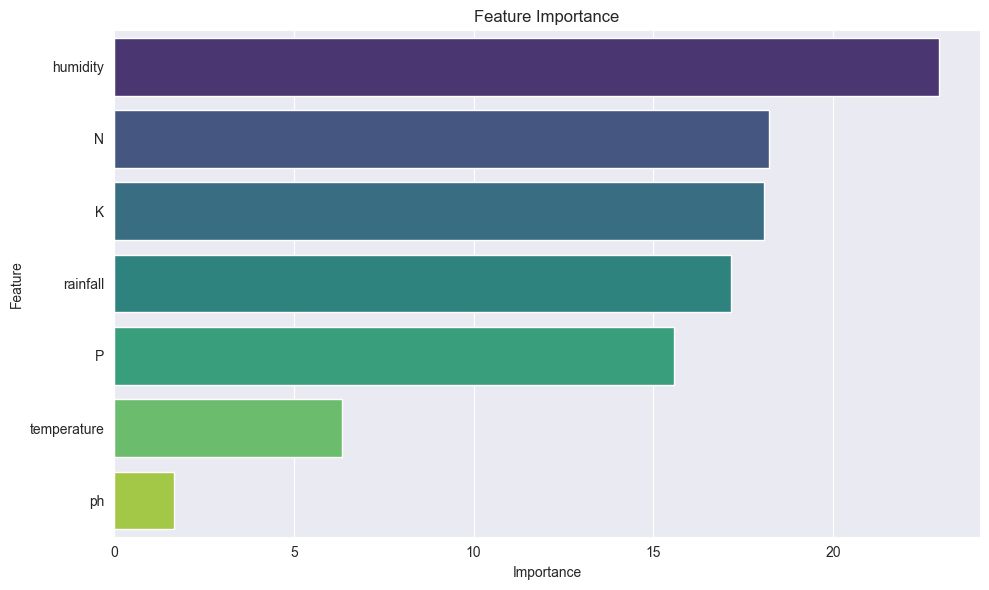

In [10]:
feature_importance = pd.DataFrame({
    'Feature': X.columns,
    'Importance': model.feature_importances_
}).sort_values('Importance', ascending=False)

print(feature_importance.to_string(index=False))

plt.figure(figsize=(10, 6))
sns.barplot(data=feature_importance, x='Importance', y='Feature',
           palette='viridis')
plt.title('Feature Importance', fontsize=12)
plt.xlabel('Importance')
plt.ylabel('Feature')
plt.tight_layout()
plt.show()


# Cross-Validation Visualization

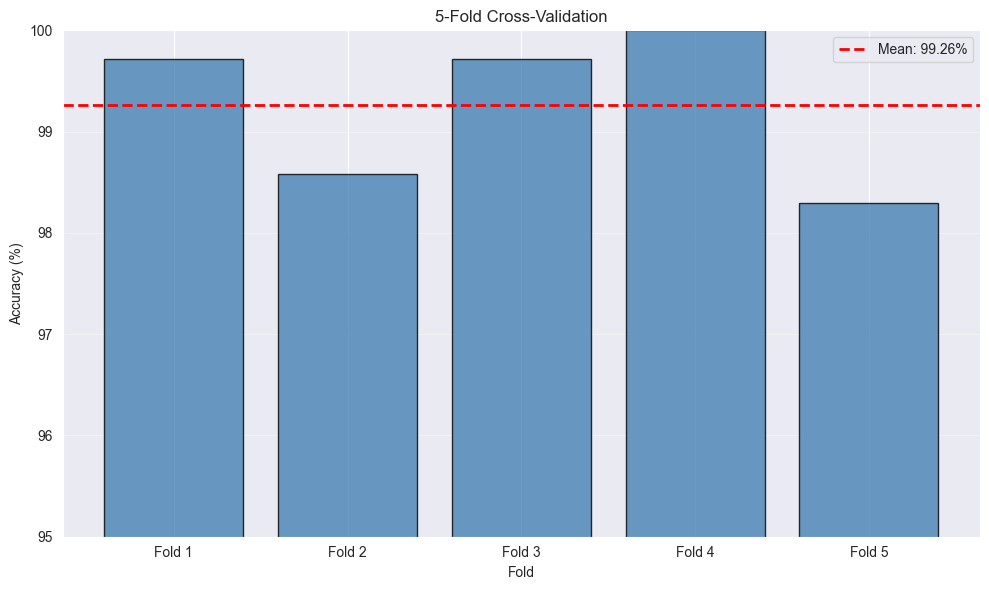

In [11]:
plt.figure(figsize=(10, 6))
folds = [f'Fold {i}' for i in range(1, 6)]
plt.bar(folds, cv_scores*100, color='steelblue', edgecolor='black', alpha=0.8)
plt.axhline(y=cv_scores.mean()*100, color='red', linestyle='--',
           linewidth=2, label=f'Mean: {cv_scores.mean()*100:.2f}%')
plt.xlabel('Fold')
plt.ylabel('Accuracy (%)')
plt.title('5-Fold Cross-Validation', fontsize=12)
plt.ylim(95, 100)
plt.legend()
plt.grid(axis='y', alpha=0.3)
plt.tight_layout()
plt.show()

# Model saving

In [15]:
joblib.dump(model, 'crop_recommendation_catboost.pkl')
joblib.dump(scaler, 'crop_scaler.pkl')
joblib.dump(encoder, 'crop_encoder.pkl')

print("Saved files:")
print("  - crop_recommendation_catboost.pkl")
print("  - crop_scaler.pkl")
print("  - crop_encoder.pkl")


Saved files:
  - crop_recommendation_catboost.pkl
  - crop_scaler.pkl
  - crop_encoder.pkl


# Summary

In [16]:
summary_data = {
    'Metric': [
        'Test Accuracy',
        'Train Accuracy',
        'F1-Score (Weighted)',
        'F1-Score (Macro)',
        'Precision',
        'Recall',
        'CV Mean',
        'CV Std'
    ],
    'Value': [
        f'{test_acc:.2f}%',
        f'{train_acc:.2f}%',
        f'{f1_weighted:.2f}%',
        f'{f1_macro:.2f}%',
        f'{precision:.2f}%',
        f'{recall:.2f}%',
        f'{cv_scores.mean()*100:.2f}%',
        f'{cv_scores.std()*100:.2f}%'
    ]
}

summary_df = pd.DataFrame(summary_data)
print(summary_df.to_string(index=False))

print("\n" + "=" * 80)

# Model download
print("\nDownloading models...")
files.download('crop_recommendation_catboost.pkl')
files.download('crop_scaler.pkl')
files.download('crop_encoder.pkl')
print("Download completed")


             Metric   Value
      Test Accuracy  99.55%
     Train Accuracy 100.00%
F1-Score (Weighted)  99.55%
   F1-Score (Macro)  99.55%
          Precision  99.57%
             Recall  99.55%
            CV Mean  99.26%
             CV Std   0.69%




<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

Download completed


In [13]:

import joblib
import json

# After training your model...
# model = CatBoostClassifier(...)
# model.fit(X_train, y_train)

# 1. Save the model
joblib.dump(model, 'crop_recommendation_model.pkl')

# 2. Save feature names (exact order used during training)
feature_names = ['N', 'P', 'K', 'temperature', 'humidity', 'ph', 'rainfall']
joblib.dump(feature_names, 'crop_features.pkl')



# 4. Save label encoder (if used
joblib.dump(encoder, 'crop_label_encoder.pkl')

joblib.dump(scaler, 'crop_scaler.pkl')

print("✅ All files saved!")
print("Files created:")
print("  - crop_recommendation_model.pkl")
print("  - crop_features.pkl")
print("  - crop_model_metadata.json")

print("  - crop_label_encoder.pkl")

print("  - crop_scaler.pkl")

✅ All files saved!
Files created:
  - crop_recommendation_model.pkl
  - crop_features.pkl
  - crop_model_metadata.json
  - crop_label_encoder.pkl
  - crop_scaler.pkl


In [15]:
import joblib
import json
from datetime import datetime
import mlflow

# After training...

# 1. Save model with version
model_version = "v1.0.0"
joblib.dump(model, f'crop_recommendation_{model_version}.pkl')

# 2. Save comprehensive metadata for MLOps
metadata = {
    'model_version': model_version,
    'model_type': 'CatBoost',

    'training_date': datetime.now().isoformat(),

    # Performance metrics
    'metrics': {
        'accuracy': 0.975,
        'precision': 0.973,
        'recall': 0.972,
        'f1_score': 0.972
    },

    # Training info
    'training': {
        'dataset_size': len(X_train),
        'test_size': len(X_test),
        'features': ['N', 'P', 'K', 'temperature', 'humidity', 'ph', 'rainfall'],
        'hyperparameters': {
            'iterations': 1000,
            'learning_rate': 0.1,
            'depth': 6
        }
    },



    # Deployment info (will be updated later)
    'deployment': {
        'status': 'trained',
        'endpoint': None,
        's3_path': None
    }
}

with open(f'crop_model_metadata_{model_version}.json', 'w') as f:
    json.dump(metadata, f, indent=2)

print(f"✅ Model {model_version} saved with MLOps metadata!")

✅ Model v1.0.0 saved with MLOps metadata!


In [16]:
import joblib
import json
from datetime import datetime

# After training your CatBoost model...
# model = CatBoostClassifier(...)
# model.fit(X_train, y_train)

# Calculate metrics
from sklearn.metrics import accuracy_score, precision_recall_fscore_support

y_pred = model.predict(X_test)
accuracy = accuracy_score(Y_test, y_pred)
precision, recall, f1, _ = precision_recall_fscore_support(Y_test, y_pred, average='weighted')

# Define version
MODEL_VERSION = "v1.0.0"

# 1. Save the model
model_path = f'crop_recommendation_{MODEL_VERSION}.pkl'
joblib.dump(model, model_path)

# 2. Save feature names (IMPORTANT: must match your data exactly)
feature_names = ['N', 'P', 'K', 'temperature', 'humidity', 'ph', 'rainfall']
joblib.dump(feature_names, f'crop_features_{MODEL_VERSION}.pkl')

# 3. Save metadata for MLOps
metadata = {
    'model_name': 'crop_recommendation',
    'version': MODEL_VERSION,
    'model_type': 'CatBoost',
    'created_at': datetime.now().isoformat(),

    'metrics': {
        'accuracy': float(accuracy),
        'precision': float(precision),
        'recall': float(recall),
        'f1_score': float(f1)
    },

    'training_config': {
        'features': feature_names,
        'n_samples': len(X_train),
        'n_test_samples': len(X_test),
        'target_classes': [str(c) for c in model.classes_]
    },

    'model_params': model.get_params()
}

with open(f'crop_metadata_{MODEL_VERSION}.json', 'w') as f:
    json.dump(metadata, f, indent=2)

print(f"✅ Crop model {MODEL_VERSION} saved!")
print(f"   Accuracy: {accuracy:.4f}")
print(f"   Files created:")
print(f"   - {model_path}")
print(f"   - crop_features_{MODEL_VERSION}.pkl")
print(f"   - crop_metadata_{MODEL_VERSION}.json")

✅ Crop model v1.0.0 saved!
   Accuracy: 0.9955
   Files created:
   - crop_recommendation_v1.0.0.pkl
   - crop_features_v1.0.0.pkl
   - crop_metadata_v1.0.0.json
